In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")

In [24]:
import numpy as np
import pandas as pd
import pymc
import statsmodels.api as sm
from scipy.optimize import minimize, minimize_scalar

# Commencer ici

In [4]:
df = pd.read_csv("BaseFinale",index_col=0)
base_continent = df[df["Map Name"] == "Naissance d'une théorie:  de la dérive des continents à l'expansion océanique"]
base_regard = df[df['Map Name'] == "Transformer son regard"]
base_autres = df[df['Map Name'] == "Transformer les autres"]
base_adn = df[(df['Map Name'] == "L'ADN [copy] [copie]") |(df['Map Name'] == "L'ADN [copy]") | (df['Map Name'] == "L'ADN")]

# Bayes Network MotherF####R

In [ ]:
base = base_regard.copy()

In [ ]:
list_nom = dict(set([(b,a) for a,b in (base[["capsule name","Capsule id"]].values)]))
list_orig_dest = dict(set([(a,b) for a,b in (base[["Capsule id","list Destination"]].values)]))

In [ ]:
list_capsule = {}
for id_c in list_nom.keys():
    list_capsule[id_c] = base[base["Capsule id"] == id_c]
    list_capsule[id_c].drop("Capsule id", axis=1, inplace = True)
    list_capsule[id_c].sort("date created")
    list_capsule[id_c].drop([
                            "date created",
                             "date joined",
                             'date updated',
                             'author user name',
                             'user name',
                             'type of author',
                             'user id',
                             'author user id',
                             'test attempt',
                             'capsule name',
                             'Map Name',
                             'map id',
                             'list Destination',
                             'is draft',
                             'is public'
                                
                            ], axis=1, inplace=True)
    list_capsule[id_c]["delta approximate real duration"] = list_capsule[id_c]["approximate capsule duration"] - \
                                                            list_capsule[id_c]["duration"]
    list_capsule[id_c].drop(["approximate capsule duration"], axis=1, inplace=True)
    list_capsule[id_c].reset_index

In [ ]:
dict_questions = {}
for capsule_id, capsule in list_capsule.iteritems():
    n_questions = capsule["question number"].max()
    dict_questions[capsule_id] = n_questions
dict_questions

In [ ]:
from pymc import DiscreteUniform, Uniform, Bernoulli

alpha = Uniform('alpha', lower=0., upper=1.)
beta = Uniform('beta',lower=alpha, upper=1.)
mu = Uniform('mu', lower=0., upper=1.)
ksi = Uniform('ksi',lower=mu, upper=1.)
capsule_dict = {}
for capsule_id, nom in list_nom.iteritems():
    if list_orig_dest[capsule_id] is nan:
        capsule_dict[capsule_id] = Bernoulli('capsule_'+nom, p=0.5)

In [ ]:
from pymc import Lambda, Deterministic
S = {}
p = {}
for capsule_id, list_dest in list_orig_dest.iteritems():
    if list_orig_dest[capsule_id] is not nan:
        dict_dest = {capsule_id_dest: value for capsule_id_dest, value in capsule_dict.iteritems() if capsule_id_dest in list_dest}
        S[capsule_id] = (sum(dict_dest.values()))/float(len(dict_dest))
        p1 = (S[capsule_id]*mu + (1-S[capsule_id])*ksi)
        p[capsule_id] = p1
        capsule_dict[capsule_id] = Bernoulli('capsule_'+list_nom[capsule_id], p=max(1e-6,p[capsule_id]))


In [ ]:
S['570ce2c20a728f61eeaca941']

In [ ]:
import pymc
question_va_dict = {}
p_question = []
for capsule_id, capsule in capsule_dict.iteritems():
    capsule_df = list_capsule[capsule_id]
    for i in range(dict_questions[capsule_id]):
        p2 = capsule*beta+(1-capsule)*alpha
        p_question.append(p2)
        question_va_dict[(i,capsule_id)] = Bernoulli("question_"+str(i+1)+"_capsule_"+list_nom[capsule_id][-1:],
                                                    p=max(1e-6,p_question[-1]),
                                                    value=capsule_df[capsule_df["question number"]==i]["success"],
                                                    observed=True
                                                    )

In [ ]:
M.stats()

In [ ]:
from pymc import Model
from pymc.graph import dag, graph, moral_graph
from IPython.display import Image, display

model = Model(capsule_dict.values()+p.values()+question_va_dict.values()+p_question)
graph = graph(model)
Image(graph.create_png())

In [ ]:
from pymc import MCMC
M = MCMC([alpha,beta,mu,ksi]+capsule_dict.values()+question_va_dict.values())
M.sample(iter=5000)

In [ ]:
from pymc.Matplot import plot
len(M.trace("mu")[:])

In [ ]:
from pymc import Matplot
Matplot.plot(M)

In [ ]:
dict_trace = {}
for capsule_id, nom in list_nom.iteritems():
    dict_trace[nom] = np.mean(M.trace("capsule_"+nom)[:])
    try:
        dict_trace["p_"+nom] = [a.value for a in M.trace("p_"+nom)[:]]
        for i in range(11):
            try:
                dict_trace["p_"+nom+"_question_"+str(i+1)] = np.mean([a.value for a in M.trace("p_"+nom+"_question_"+str(i+1))[:]])
            except:
                pass
    except:
        pass
dict_trace


# Item Response Theory

In [4]:
def proba_irt(a,b,c,theta):
    n_question = len(a)
    p = np.zeros(n_question)
    for i in range(n_question):
        p[i] = c[i] + (1.-c[i])/(1.+exp(-a[i]*(theta-b[i])))
    return p

In [135]:
p_test = proba_irt([0.4,2],[.8,3.],[0.,0.],3.)
p_test

array([ 0.70682222,  0.5       ])

In [5]:
"""a = np.array([0.4,2])
b = np.array([.8,3.])
c = np.array([0.,0.])
u = np.array([1.,0.])"""
def neg_log_likelihood(a,b,c,u,X):
    p = proba_irt(a,b,c,X)
    n = len(u)
    ones = np.ones(n)
    return -np.sum(u*log(p)+(ones-u)*log(ones-p))

In [6]:
neg_log_likelihood([10000.,10000.],[0.,0.],[0.5,0.5],[1.,0.],1.)

nan

In [929]:
u = np.array([1.,1.])
p = np.array([0.5,0.5])
ones = np.ones(2)
-np.sum(u*p+(ones-u)*(ones-p))

-1.0

In [23]:
def opt_theta(a,b,c,u):
    return minimize_scalar(lambda x: neg_log_likelihood(a,b,c,u,x), tol=1e-6).x

In [26]:
opt_theta(np.array([0.4,2]), np.array([.8,3.]),np.array([.3,.2]), np.array([0.,0.]))

-178.67148215971733

$$ I_{U_{i_1},..,U_{i_{k-1}}}(\theta) =  \sum_{j=1}^{k-1}{\frac{p'_{i_j}(\theta)^2}{p_{i_j}(\theta)\cdot(1-p_{i_j}(\theta))}}$$
On va aussi utiliser le fait que :
$$ p'_{i_j}(\theta) = \frac{a_{i_j}\cdot(p_{i_j}(\theta)-c_{i_j})\cdot(1-p_{i_j}(\theta))}{1-c_{i_j}}$$


In [9]:
def fish_info_part(a_k,b_k,c_k,theta):
    p_k = proba_irt([a_k],[b_k],[c_k],theta)
    q_k = 1- p_k
    dp_k = float(a_k/(1-c_k))*(p_k-c_k)*q_k
    return dp_k**2/(p_k*q_k)

In [10]:
def find_max_info(R,theta):
    m = np.argmax([fish_info_part(a_k,b_k,c_k, theta) for a_k,b_k,c_k in R])
    return(m)

In [11]:
from sklearn.linear_model import LogisticRegression
def update_parameters(data,target):
    train_cols = data.columns - [target]
    logit = sm.Logit(data[target], data[train_cols])
    #logit = LogisticRegression()
    #result = logit.fit(data[train_cols],data[target])
    #return result.coef_
    result = logit.fit()
    return result
    

In [12]:
data = pd.DataFrame.from_dict({'question_i':[0.,1.,1.],'theta':[3.,14.,2.]})
data['intercept'] = 1.
update_parameters(data,'question_i').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             question_i   No. Observations:                    3
Model:                          Logit   Df Residuals:                        1
Method:                           MLE   Df Model:                            1
Date:                Wed, 03 Aug 2016   Pseudo R-squ.:                  0.1792
Time:                        12:09:18   Log-Likelihood:                -1.5674
converged:                       True   LL-Null:                       -1.9095
                                        LLR p-value:                    0.4081
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.5448      2.000     -0.272      0.785      -4.465       3.375
theta          0.2551      0.427      0.597      0.550      -0.582       1.092
==============================================================================
"""

In [ ]:
range(100)

# Création d'un dataset de simulation pour theta fixe et on cherche à estimer a et b

In [994]:
dico = {}
dico["user"] = []
list_questions = np.array([[1.,4.,0.],[2.,1.,0.],[3.,4.,0.],[4.,1.2,0.],[5.,0.,0.]])
for i in range(100):
    dico['user'] += ["user"+str(i+1)]
dico['theta'] = np.random.randn(len(dico['user']))
#pd.DataFrame.from_dict(dico)

In [995]:
list_answers = [list_questions.T[0]*(np.ones(len(list_questions.T[1]))*theta-list_questions.T[1])+np.random.logistic(len(list_questions.T[1]))>0 for theta in dico['theta']]

In [996]:
for i in range(len(np.array(list_questions).T)):
    dico['answer'+str(i+1)] = np.array(list_answers).T[i]
data = pd.DataFrame.from_dict(dico)
#for i in range(5):
#    data['question'+str(i+1)]=data['proba'+str(i+1)].apply(lambda x: 1 if x >= 0.5 else 0)
data["intercept"] =1.

# Question difficile en terme de distinction entre 0 et 1

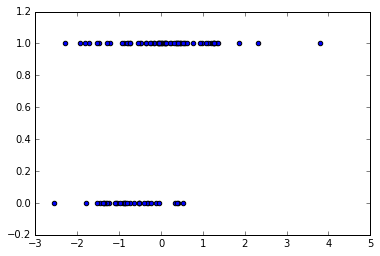

In [997]:
plt.scatter(data['theta'],np.array(list_answers).T[0])

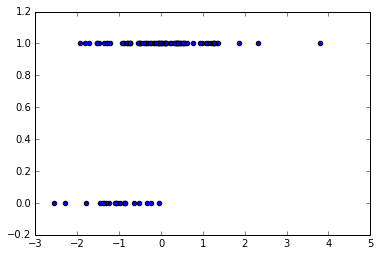

In [998]:
plt.scatter(data['theta'],np.array(list_answers).T[1])

In [999]:
update_parameters(data[['answer2','theta','intercept']], 'answer2').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                answer2   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Tue, 02 Aug 2016   Pseudo R-squ.:                  0.2537
Time:                        18:49:22   Log-Likelihood:                -37.346
converged:                       True   LL-Null:                       -50.040
                                        LLR p-value:                 4.685e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3642      0.452      5.230      0.000       1.478       3.250
theta          1.6972      0.423      4.012      0.000       0.868       2.526
==============================================================================
"""

In [1000]:
2.9851/2.0221

1.4762375747984768

# a et b fixés on cherche à retrouver theta en posant 50 questions

In [27]:
# Le theta à retrouver
theta = 0.73
# Nombre de questions
n_questions = 100
list_questions = np.random.rand(n_questions,3)*20
list_questions
list_answers = [
    list_questions.T[0]
    *(np.ones(len(list_questions.T[1]))*theta
    -list_questions.T[1])
    +np.random.logistic(len(list_questions.T[1]))
    >0
]
np.mean(list_answers)

0.66000000000000003

In [554]:
l = np.array([0,1,2])
np.delete(l,[1,2])

array([0])

In [31]:
list_theta_guess = []
list_index = np.array(range(len(list_answers[0])))
j = 0
i_j = [0]
R = list_index.copy()
R = np.delete(R,0)
while (len(i_j) != len(list_answers[0]))and(i_j[-1] != "done"):
    theta_i = opt_theta(
        list_questions.T[0][i_j],
        list_questions.T[1][i_j],
        list_questions.T[2][i_j],
        list_answers[0][i_j]
    )
    list_theta_guess.append(theta_i)
    k = find_max_info(list_questions[R],theta_i)
    i_j.append(R[k])
    R = np.delete(R,k)
    print(j)
    j+=1
    
    
    
    
    
    

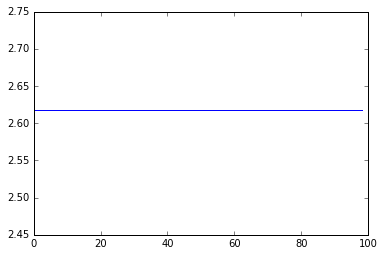

In [32]:
plt.plot(list_theta_guess)

In [18]:
len(i_j)

100